In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

In [2]:
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import ImageGrab

import cv2
#//cap = cv2.VideoCapture(0)

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")


# ## Object detection imports
# Here are the imports from the object detection module.

# In[3]:

from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

In [3]:
# # Model preparation 

# ## Variables
# 
# Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_CKPT` to point to a new .pb file.  
# 
# By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.



# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = r"C:\Users\user\Documents\models\research\object_detection\data\mscoco_label_map.pbtxt"

NUM_CLASSES = 90


# ## Download Model

opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

In [4]:
# ## Load a (frozen) Tensorflow model into memory.


detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.compat.v1.GraphDef()
  with tf.io.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    

In [5]:
# ## Loading label map
# Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [100]:
# # Detection
import grab_screen
import time
#import numpy as num
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
#PATH_TO_TEST_IMAGES_DIR = 'test_images'
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)
time.sleep(5)


with detection_graph.as_default():
    with tf.compat.v1.Session(graph=detection_graph) as sess:
        while True:
      #ret, image_np = cap.read()
            image=ImageGrab.grab(bbox =(115,250,1300, 880))
            image=np.array(image)
            rp=image
          #screen = cv2.resize(grab_screen(), (800,450))
            image_np = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
          # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
          # Each box represents a part of the image where a particular object was detected.
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
          # Each score represent how level of confidence for each of the objects.
          # Score is shown on the result image, together with the class label.
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
          # Actual detection.
            (boxes, scores, classes, num_detections) = sess.run(
              [boxes, scores, classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
            for i in range(len(scores[0])):
                if classes[0][i]==3 or classes[0][i]==6 or classes[0][i]==8 or classes[0][i]==1 or classes[0][i]==2:
                    if scores[0][i]>0.5:
                        mid_x=(boxes[0][i][1] + boxes[0][i][3])/2
                        mid_y=(boxes[0][i][0] + boxes[0][i][2])/2

                        distance=round((boxes[0][i][3] - boxes[0][i][1]),2)
                        height=round(680-(boxes[0][i][2])*680,2)#from bottom of the display to the bottom of the bounding box
                        
                        #print(height)
                        #print(distance)
                        if classes[0][i]==1 or classes[0][i]==2:
                            if distance>=0.06:#reducing the distance for person and bycycle since they are thin
                                cv2.putText(image_np, '{:.2f}'.format(distance), (int(mid_x*1185),int(mid_y*630+50)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
                                if mid_x>=0.22 and mid_x<=0.78 and height<20.0:
                                    cv2.putText(image_np,"WARNING!!!", (int(mid_x*1185-50),int(mid_y*630)), cv2.FONT_HERSHEY_TRIPLEX, 1, (0,0,255), 2)
                        else: 
                            # warning message and distance message for cars/bus/truck
                            if distance>=0.25:
                                cv2.putText(image_np, '{:.2f}'.format(distance), (int(mid_x*1185),int(mid_y*630+50)), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,255,255), 2)
                            # Visualization of the results of a detection
                                if distance>=0.34 and mid_x>=0.25 and mid_x<=0.80 and height<18.0:
                                    cv2.putText(image_np,"WARNING!!!", (int(mid_x*1185-50),int(mid_y*630)), cv2.FONT_HERSHEY_TRIPLEX, 1.2, (0,0,255), 2)

            vis_util.visualize_boxes_and_labels_on_image_array(
              image_np,
              np.squeeze(boxes),
              np.squeeze(classes).astype(np.int32),
              np.squeeze(scores),
              category_index,
              use_normalized_coordinates=True,
              line_thickness=8)

          #cv2.namedWindow("object detection", cv2.WINDOW_NORMAL)
          #cv2.resizeWindow("object detection",)  
            cv2.imshow('object detection', cv2.resize(image_np, (500,300)))
            if cv2.waitKey(25) & 0xFF == ord('q'):
                cv2.destroyAllWindows()
                break

In [86]:
print("boxes:",boxes.shape)
print("classes:",classes.shape)
print("scores:",scores.shape)

boxes: (1, 100, 4)
classes: (1, 100)
scores: (1, 100)


In [87]:
classes[0]

array([ 3.,  3.,  3.,  3.,  3.,  3.,  1.,  3.,  6.,  6.,  1.,  6.,  3.,
        6.,  3.,  3.,  3.,  3.,  3.,  1.,  1.,  3.,  3., 10.,  1.,  1.,
       10.,  1.,  3.,  3.,  3.,  3.,  1.,  1.,  1.,  6.,  3.,  1.,  8.,
        1.,  3.,  3.,  1.,  3.,  3., 10., 10.,  3.,  3.,  3.,  6.,  3.,
        3.,  6.,  3.,  3.,  3.,  1.,  3., 10.,  3.,  8.,  3.,  3.,  6.,
        1.,  1.,  6.,  3.,  3.,  3.,  3.,  8.,  1.,  1.,  8.,  3.,  3.,
        6.,  1.,  3.,  6.,  6.,  3.,  6., 10.,  8.,  3.,  1.,  1.,  1.,
        3., 33.,  3.,  6.,  6., 10.,  3.,  3.,  6.], dtype=float32)

In [88]:
indx=[]
score=[]
for i in range(len(scores[0])):
    if scores[0][i]>0.7:
        score.append(scores[0][i])
        indx.append(i)

In [89]:
#import numpy as num

In [90]:
indx=np.array(indx)

In [91]:
indx

array([0, 1])

In [92]:
boxes[0][indx][0]

array([0.5481652, 0.0066765, 0.9516399, 0.3447961], dtype=float32)

In [93]:
print((boxes[0][indx][0][3]-boxes[0][indx][0][1]))
print((boxes[0][indx][0][2]-boxes[0][indx][0][0]))

0.3381196
0.4034747


In [94]:
print(((boxes[0][indx][0][3]+boxes[0][indx][0][1])/2)*1185)
print(((boxes[0][indx][0][2]+boxes[0][indx][0][0])/2)*680)

208.24750743806362
509.9337315559387


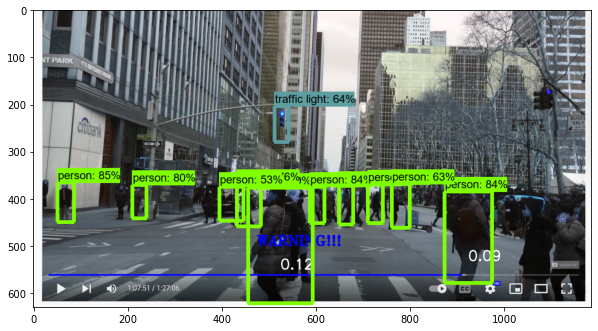

In [101]:
plt.figure(figsize=(10,10))
plt.imshow(image_np)